In [585]:
import os
import json
import math
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from plotly.subplots import make_subplots
from concurrent.futures import ThreadPoolExecutor as Pool
from config import SMACV1_ENV_NAMES, SMACV2_ENV_NAMES, MAMUJOCO_ENV_NAMES

In [586]:
ALGO_NAMES = ["BC", "IIPL", "IPLVDN", "SLMARL", "OMAPL"]
ALGO_NAMES_MAPS = {
    "BC": "BC",
    "IIPL": "IIPL",
    "IPLVDN": "IPL-VDN",
    "SLMARL": "SL-MARL",
    "OMAPL": "O-MAPL",
}

colors = px.colors.qualitative.Plotly
COLOR_MAPS = {
    "SLMARL": colors[0],
    "OMAPL": colors[1],
    "IPVDN": colors[2],
    "BC": "#feb406",
    "IIPL": "#d366ff",
}

In [587]:
def load_results(task_name, step):
    path = f"saved_results_final/{task_name}/step{step}.json"
    if not os.path.exists(path):
        print(f"Missing data for {task_name} at step {step}")
        return None
    with open(path, "r") as f:
        return json.load(f)

In [588]:
def get_results(algos, use_llm=False):
    if use_llm:
        path = "saved_results_final/results_llm.pkl"
    else:
        path = "saved_results_final/results.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f)
        data_returns = data["returns"]
        data_winrates = data["winrates"]
    return data_returns, data_winrates


    with Pool() as p:
        tasks = []
        for algo in algos:
            for env_name in MAMUJOCO_ENV_NAMES + SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
                for step in range(101):
                    for seed in range(4):
                        if use_llm:
                            if env_name in MAMUJOCO_ENV_NAMES:
                                continue
                            task_name = f"{algo}/{env_name}_llm/seed{seed}"
                        else:
                            task_name = f"{algo}/{env_name}/seed{seed}"

                        tasks.append((env_name, algo, step, p.submit(load_results, task_name, step)))
        
        data_returns = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        data_winrates = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        for env_name, algo, step, task in tasks:
            data = task.result()
            if data is None:
                continue
            data_returns[env_name][algo][step].append(data["returns"])
            if "winrates" in data:
                data_winrates[env_name][algo][step].append(data["winrates"])
    return data_returns, data_winrates

In [589]:
def analyze(x, tag="returns"):
    if isinstance(x, float):
        return x
    ids = list(x.keys())
    x = [x[i] for i in ids[-4:]]
    if len(x) == 0:
        return "NaN"
    x = np.array(x).mean(axis=1)
    mean = np.mean(x)
    std = np.std(x)
    if tag == "returns":
        return f"{mean:.1f} ± {std:.1f}"
    else:
        return f"{100*mean:.1f} ± {100*std:.1f}"

In [590]:
data_returns, data_winrates = get_results(ALGO_NAMES, use_llm=False)
returns_pd = pd.DataFrame(data_returns).T.rename(columns=ALGO_NAMES_MAPS)
winrates_pd = pd.DataFrame(data_winrates).T.rename(columns=ALGO_NAMES_MAPS)

In [591]:
returns_pd.applymap(analyze)

,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL
Hopper-v2,808.1 ± 39.1,782.0 ± 81.5,846.6 ± 65.4,890.0 ± 88.7,1114.4 ± 154.1
Ant-v2,1303.9 ± 122.0,1312.0 ± 155.6,1376.1 ± 142.0,1334.1 ± 150.9,1406.4 ± 163.7
HalfCheetah-v2,4119.9 ± 350.7,4028.8 ± 430.0,4287.5 ± 273.1,4233.9 ± 303.1,4382.0 ± 189.7
2c_vs_64zg,19.0 ± 1.1,19.3 ± 0.8,19.3 ± 1.1,19.2 ± 0.8,19.3 ± 1.4
5m_vs_6m,11.1 ± 2.1,10.8 ± 2.0,11.2 ± 2.0,11.1 ± 2.1,11.5 ± 2.1
6h_vs_8z,11.0 ± 0.8,10.8 ± 0.7,11.7 ± 1.0,11.8 ± 1.0,12.1 ± 1.3
corridor,19.4 ± 1.0,19.4 ± 1.0,19.6 ± 1.0,14.3 ± 2.8,19.6 ± 0.9
protoss_5_vs_5,15.4 ± 2.4,14.3 ± 2.5,17.1 ± 2.7,15.8 ± 2.7,16.8 ± 2.4
protoss_10_vs_10,16.0 ± 2.0,15.4 ± 2.1,17.8 ± 2.3,16.4 ± 2.4,17.9 ± 1.9
protoss_10_vs_11,12.5 ± 2.3,12.7 ± 2.4,14.7 ± 2.3,14.2 ± 2.2,14.9 ± 2.0


In [592]:
winrates_pd.applymap(lambda x: analyze(x, tag="winrates"))

,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL
2c_vs_64zg,59.6 ± 25.0,60.4 ± 24.7,71.1 ± 22.0,63.5 ± 24.0,74.4 ± 24.7
5m_vs_6m,16.8 ± 18.0,14.3 ± 17.0,16.8 ± 18.0,16.0 ± 18.9,19.3 ± 19.6
6h_vs_8z,0.6 ± 3.8,0.2 ± 2.2,2.5 ± 7.6,1.6 ± 6.8,4.5 ± 11.0
corridor,89.3 ± 15.5,89.8 ± 15.4,93.9 ± 11.6,49.0 ± 22.8,93.2 ± 13.5
protoss_5_vs_5,38.1 ± 24.2,31.4 ± 25.2,54.5 ± 25.9,49.0 ± 28.2,54.3 ± 24.2
protoss_10_vs_10,38.7 ± 24.2,28.5 ± 21.8,47.9 ± 27.2,40.6 ± 23.2,53.7 ± 23.6
protoss_10_vs_11,12.7 ± 17.4,12.5 ± 16.5,22.3 ± 21.0,18.6 ± 18.8,30.7 ± 19.8
protoss_20_vs_20,39.8 ± 24.9,35.4 ± 21.5,57.0 ± 24.8,38.7 ± 23.1,59.8 ± 23.2
protoss_20_vs_23,15.2 ± 18.5,9.0 ± 14.2,22.7 ± 21.7,11.1 ± 14.6,23.4 ± 19.2
terran_5_vs_5,27.5 ± 24.0,26.2 ± 19.5,36.3 ± 24.8,34.2 ± 23.4,39.5 ± 24.7


In [593]:
data_returns_llm, data_winrates_llm = get_results(ALGO_NAMES, use_llm=True)
returns_pd_llm = pd.DataFrame(data_returns_llm).T.rename(columns=ALGO_NAMES_MAPS)
winrates_pd_llm = pd.DataFrame(data_winrates_llm).T.rename(columns=ALGO_NAMES_MAPS)

In [594]:
returns_pd_llm.applymap(analyze)

,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL
2c_vs_64zg,19.4 ± 0.9,19.3 ± 0.9,19.6 ± 1.0,19.5 ± 0.7,19.6 ± 1.1
5m_vs_6m,11.3 ± 2.1,10.8 ± 2.0,11.4 ± 2.2,11.2 ± 2.1,11.5 ± 2.3
6h_vs_8z,11.1 ± 0.8,10.9 ± 0.7,11.9 ± 1.1,11.8 ± 1.2,12.2 ± 1.3
corridor,19.4 ± 1.0,19.4 ± 1.0,19.7 ± 0.9,15.1 ± 2.4,19.7 ± 0.8
protoss_5_vs_5,16.7 ± 2.7,15.9 ± 2.5,17.6 ± 2.5,16.9 ± 2.4,17.9 ± 2.5
protoss_10_vs_10,16.5 ± 2.0,16.6 ± 2.2,17.9 ± 1.8,17.5 ± 1.8,18.0 ± 2.1
protoss_10_vs_11,14.7 ± 2.3,14.5 ± 2.0,15.4 ± 2.4,14.0 ± 2.4,16.5 ± 2.2
protoss_20_vs_20,17.2 ± 1.7,17.6 ± 1.7,18.5 ± 1.3,18.2 ± 1.9,18.9 ± 1.5
protoss_20_vs_23,14.3 ± 2.0,13.4 ± 1.8,15.1 ± 1.8,14.3 ± 1.8,15.8 ± 1.9
terran_5_vs_5,11.8 ± 3.3,12.5 ± 3.1,13.4 ± 2.9,12.6 ± 3.1,12.6 ± 2.6


In [595]:
winrates_pd_llm.applymap(lambda x: analyze(x, tag="winrates"))

,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL
2c_vs_64zg,65.6 ± 24.6,60.2 ± 25.9,77.0 ± 21.3,65.2 ± 21.2,79.5 ± 19.6
5m_vs_6m,18.2 ± 18.4,15.0 ± 17.5,18.0 ± 19.2,17.4 ± 19.4,20.7 ± 20.5
6h_vs_8z,0.8 ± 4.3,0.4 ± 3.1,3.5 ± 9.2,3.7 ± 8.9,6.1 ± 11.2
corridor,89.6 ± 15.5,90.6 ± 13.6,94.5 ± 12.5,57.6 ± 22.2,94.5 ± 11.2
protoss_5_vs_5,48.4 ± 25.9,41.0 ± 24.2,58.8 ± 24.5,54.3 ± 24.0,61.5 ± 24.8
protoss_10_vs_10,46.3 ± 24.0,41.0 ± 24.4,57.0 ± 23.4,52.5 ± 22.1,61.1 ± 24.8
protoss_10_vs_11,22.7 ± 22.2,15.6 ± 15.9,27.3 ± 24.7,20.9 ± 20.9,34.4 ± 24.8
protoss_20_vs_20,48.4 ± 25.3,43.6 ± 23.6,61.5 ± 22.1,51.8 ± 25.0,64.5 ± 23.5
protoss_20_vs_23,18.0 ± 17.4,9.4 ± 14.7,23.4 ± 21.4,12.1 ± 15.9,26.4 ± 20.8
terran_5_vs_5,31.1 ± 22.9,34.8 ± 23.0,41.0 ± 23.7,36.7 ± 24.8,43.0 ± 23.0


In [596]:
# combine columns: returns_pd & returns_pd_llm
returns_combined = pd.concat([returns_pd, returns_pd_llm], axis=1)
winrates_combined = pd.concat([winrates_pd, winrates_pd_llm], axis=1)

In [597]:
returns_combined.applymap(analyze)

,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL
Hopper-v2,808.1 ± 39.1,782.0 ± 81.5,846.6 ± 65.4,890.0 ± 88.7,1114.4 ± 154.1,NaN,NaN,NaN,NaN,NaN
Ant-v2,1303.9 ± 122.0,1312.0 ± 155.6,1376.1 ± 142.0,1334.1 ± 150.9,1406.4 ± 163.7,NaN,NaN,NaN,NaN,NaN
HalfCheetah-v2,4119.9 ± 350.7,4028.8 ± 430.0,4287.5 ± 273.1,4233.9 ± 303.1,4382.0 ± 189.7,NaN,NaN,NaN,NaN,NaN
2c_vs_64zg,19.0 ± 1.1,19.3 ± 0.8,19.3 ± 1.1,19.2 ± 0.8,19.3 ± 1.4,19.4 ± 0.9,19.3 ± 0.9,19.6 ± 1.0,19.5 ± 0.7,19.6 ± 1.1
5m_vs_6m,11.1 ± 2.1,10.8 ± 2.0,11.2 ± 2.0,11.1 ± 2.1,11.5 ± 2.1,11.3 ± 2.1,10.8 ± 2.0,11.4 ± 2.2,11.2 ± 2.1,11.5 ± 2.3
6h_vs_8z,11.0 ± 0.8,10.8 ± 0.7,11.7 ± 1.0,11.8 ± 1.0,12.1 ± 1.3,11.1 ± 0.8,10.9 ± 0.7,11.9 ± 1.1,11.8 ± 1.2,12.2 ± 1.3
corridor,19.4 ± 1.0,19.4 ± 1.0,19.6 ± 1.0,14.3 ± 2.8,19.6 ± 0.9,19.4 ± 1.0,19.4 ± 1.0,19.7 ± 0.9,15.1 ± 2.4,19.7 ± 0.8
protoss_5_vs_5,15.4 ± 2.4,14.3 ± 2.5,17.1 ± 2.7,15.8 ± 2.7,16.8 ± 2.4,16.7 ± 2.7,15.9 ± 2.5,17.6 ± 2.5,16.9 ± 2.4,17.9 ± 2.5
protoss_10_vs_10,16.0 ± 2.0,15.4 ± 2.1,17.8 ± 2.3,16.4 ± 2.4,17.9 ± 1.9,16.5 ± 2.0,16.6 ± 2.2,17.9 ± 1.8,17.5 ± 1.8,18.0 ± 2.1
protoss_10_vs_11,12.5 ± 2.3,12.7 ± 2.4,14.7 ± 2.3,14.2 ± 2.2,14.9 ± 2.0,14.7 ± 2.3,14.5 ± 2.0,15.4 ± 2.4,14.0 ± 2.4,16.5 ± 2.2


In [598]:
winrates_combined.applymap(lambda x: analyze(x, tag="winrates"))

,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL,BC,IIPL,IPL-VDN,SL-MARL,O-MAPL
2c_vs_64zg,59.6 ± 25.0,60.4 ± 24.7,71.1 ± 22.0,63.5 ± 24.0,74.4 ± 24.7,65.6 ± 24.6,60.2 ± 25.9,77.0 ± 21.3,65.2 ± 21.2,79.5 ± 19.6
5m_vs_6m,16.8 ± 18.0,14.3 ± 17.0,16.8 ± 18.0,16.0 ± 18.9,19.3 ± 19.6,18.2 ± 18.4,15.0 ± 17.5,18.0 ± 19.2,17.4 ± 19.4,20.7 ± 20.5
6h_vs_8z,0.6 ± 3.8,0.2 ± 2.2,2.5 ± 7.6,1.6 ± 6.8,4.5 ± 11.0,0.8 ± 4.3,0.4 ± 3.1,3.5 ± 9.2,3.7 ± 8.9,6.1 ± 11.2
corridor,89.3 ± 15.5,89.8 ± 15.4,93.9 ± 11.6,49.0 ± 22.8,93.2 ± 13.5,89.6 ± 15.5,90.6 ± 13.6,94.5 ± 12.5,57.6 ± 22.2,94.5 ± 11.2
protoss_5_vs_5,38.1 ± 24.2,31.4 ± 25.2,54.5 ± 25.9,49.0 ± 28.2,54.3 ± 24.2,48.4 ± 25.9,41.0 ± 24.2,58.8 ± 24.5,54.3 ± 24.0,61.5 ± 24.8
protoss_10_vs_10,38.7 ± 24.2,28.5 ± 21.8,47.9 ± 27.2,40.6 ± 23.2,53.7 ± 23.6,46.3 ± 24.0,41.0 ± 24.4,57.0 ± 23.4,52.5 ± 22.1,61.1 ± 24.8
protoss_10_vs_11,12.7 ± 17.4,12.5 ± 16.5,22.3 ± 21.0,18.6 ± 18.8,30.7 ± 19.8,22.7 ± 22.2,15.6 ± 15.9,27.3 ± 24.7,20.9 ± 20.9,34.4 ± 24.8
protoss_20_vs_20,39.8 ± 24.9,35.4 ± 21.5,57.0 ± 24.8,38.7 ± 23.1,59.8 ± 23.2,48.4 ± 25.3,43.6 ± 23.6,61.5 ± 22.1,51.8 ± 25.0,64.5 ± 23.5
protoss_20_vs_23,15.2 ± 18.5,9.0 ± 14.2,22.7 ± 21.7,11.1 ± 14.6,23.4 ± 19.2,18.0 ± 17.4,9.4 ± 14.7,23.4 ± 21.4,12.1 ± 15.9,26.4 ± 20.8
terran_5_vs_5,27.5 ± 24.0,26.2 ± 19.5,36.3 ± 24.8,34.2 ± 23.4,39.5 ± 24.7,31.1 ± 22.9,34.8 ± 23.0,41.0 ± 23.7,36.7 ± 24.8,43.0 ± 23.0


In [599]:
def smooth(scalars, weight):
    last = 0
    smoothed = []
    for num_acc, next_val in enumerate(scalars):
        last = last * weight + (1 - weight) * next_val
        smoothed.append(last / (1 - math.pow(weight, num_acc+1)))
    return smoothed

In [600]:
def create_scatters(env_name, data_dict, y_range=None, tag="returns"):
    fig = go.Figure()
    for algo in ALGO_NAMES:
        steps = []
        values = []
        stds = []
        for step in range(101):
            data = np.array(data_dict[env_name][algo][step]).mean(axis=0)
            steps.append(step)
            values.append(data.mean())
            stds.append(data.std())
        smooth_weight = 0.8
        if env_name in SMACV1_ENV_NAMES and tag == "returns":
            smooth_weight = 0.7
        values = smooth(values, smooth_weight)

        uppers = [value + std for value, std in zip(values, stds)]
        lowers = [value - std for value, std in zip(values, stds)]

        if tag == "winrates":
            uppers = [min(1.0, value) for value in uppers]
            lowers = [max(0.0, value) for value in lowers]

        color = COLOR_MAPS.get(algo, colors[2])
        algo_name = ALGO_NAMES_MAPS.get(algo, algo)
        if algo_name == "O-MAPL":
            algo_name = "O-MAPL (ours)"

        opacity = 0.1
        fig.add_trace(go.Scatter(x=steps, y=values, mode="lines", name=algo_name, line_color=color, line_width=2.0))
        fig.add_trace(go.Scatter(x=steps+steps[::-1], y=uppers+lowers[::-1], fill="toself", fillcolor=color, line_color=color, opacity=opacity, line_width=1.5, showlegend=False))

    if tag == "winrates":
        tickformat = ".0%"
    else:
        tickformat = "~s"

    fig.update_layout(template='simple_white', margin=dict(l=0, r=0, t=0, b=0, pad=0, autoexpand=True))
    fig.update_layout(height=100, width=180)
    fig.update_xaxes(range=[0, 100], dtick=50, minor=dict(ticklen=3, nticks=4))
    fig.update_yaxes(range=y_range, tickformat=tickformat)
    return fig

In [601]:
def update_legend(fig, tag="returns", distance=1.1, yrange=None, left_margin=0, right_margin=15, bottom_margin=0):
    trace_names = []
    for trace in fig.data:
        if trace.name is not None and trace.name not in trace_names:
            trace_names.append(trace.name)
            trace.update(showlegend=True)
        else:
            trace.update(showlegend=False)
    fig.update_layout(template='simple_white', margin=dict(l=left_margin, r=right_margin, t=0, b=bottom_margin, pad=5, autoexpand=True))
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=distance, xanchor="right", x=1))

    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)

    fig.update_xaxes(range=[0, 100], dtick=50, minor=dict(ticklen=3, nticks=3))


    if tag == "winrates":
        # fig.update_yaxes(range=[0, 0.99], tickformat=".0%", dtick=0.4, minor=dict(ticklen=3, nticks=2))
        fig.update_yaxes(tickformat=".0%", minor=dict(ticklen=3, nticks=2))
    else:
        fig.update_yaxes(tickformat="~s", minor=dict(ticklen=3, nticks=2))
    if yrange is not None:
        fig.update_yaxes(range=yrange)
    return fig

In [602]:
plotly_figs = {}
for env_name in MAMUJOCO_ENV_NAMES + SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
    plotly_figs[env_name] = create_scatters(env_name, data_returns)

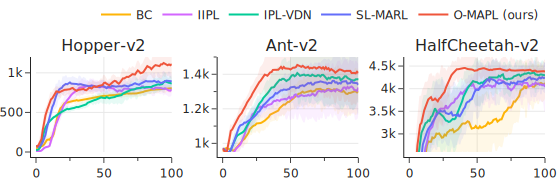

In [603]:
fig = make_subplots(rows=1, cols=3, subplot_titles=MAMUJOCO_ENV_NAMES, horizontal_spacing=0.1)
for i, env_name in enumerate(MAMUJOCO_ENV_NAMES):
    plotly_fig = plotly_figs[env_name]
    fig.add_traces(plotly_fig.data, rows=1, cols=i+1)
fig.update_layout(template='simple_white')
fig.update_layout(height=180, width=560)
fig = update_legend(fig, distance=1.3)
fig.update_yaxes(range=[0, 1200], row=1, col=1)
fig.update_yaxes(range=[950, 1500], row=1, col=2)
fig.update_yaxes(range=[2600, 4700], row=1, col=3)
fig.show("svg")
fig.write_image("graphs/mujoco_returns.pdf")

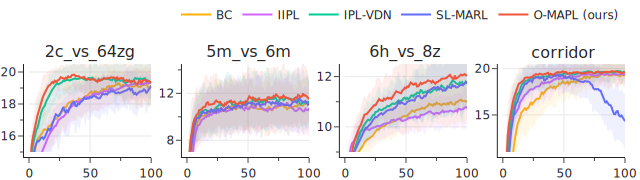

In [604]:
fig = make_subplots(rows=1, cols=4, subplot_titles=SMACV1_ENV_NAMES, horizontal_spacing=0.06)
for i, env_name in enumerate(SMACV1_ENV_NAMES):
    plotly_fig = plotly_figs[env_name]
    fig.add_traces(plotly_fig.data, rows=1, cols=i+1)
fig.update_layout(template='simple_white')
fig.update_layout(height=180, width=640)
fig = update_legend(fig, distance=1.4)
fig.update_yaxes(range=[15, 20.5], dtick=2, row=1, col=1)
fig.update_yaxes(range=[7, 14.5], dtick=4, row=1, col=2)
fig.update_yaxes(range=[9, 12.5], dtick=2, row=1, col=3)
fig.update_yaxes(range=[11, 20.5], dtick=5, row=1, col=4)
fig.show("svg")
fig.write_image("graphs/smacv1_returns.pdf")

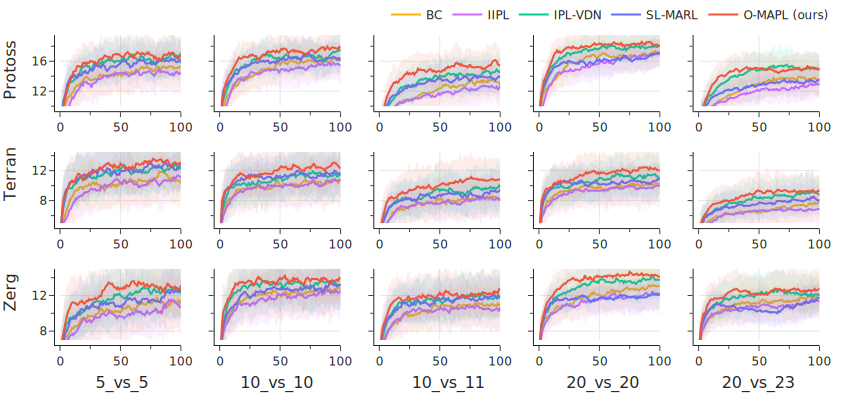

In [605]:
fig = make_subplots(
    rows=3, cols=5,
    column_titles=["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"],
    row_titles=["Protoss", "Terran", "Zerg"],
    horizontal_spacing=0.05,
    vertical_spacing=0.15
)

for i, mode in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    for j, env_name in enumerate(["protoss", "terran", "zerg"]):
        plotly_fig = plotly_figs[f"{env_name}_{mode}"]
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)

annotations = []
for i, row_title in enumerate(["Protoss", "Terran", "Zerg"]):
    annotations.append(dict(
        text=row_title,
        x=-0.065,
        y=1 - (i / 3 + 1 / 6) - 0.05 if i in [0, 1] else 1 - (i / 3 + 1 / 6 + 0.08),
        showarrow=False,
        textangle=270
    ))

for i, col_title in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    annotations.append(dict(
        text=col_title,
        x=(i / 5 + 0.08) if i in [0, 1] else (i / 5 + 0.05),
        y=-0.18 if i in [0, 1] else -0.14,
        showarrow=False,
        textangle=0
    ))

fig.update_layout(annotations=annotations)
fig.update_layout(template='simple_white')
fig.update_layout(height=400, width=850)
fig = update_legend(fig, distance=1.02, left_margin=60, bottom_margin=60)
for i in range(5):
    fig.update_yaxes(range=[10, 19.5], dtick=4, row=1, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[5, 14.5], dtick=4, row=2, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[7, 15], dtick=4, row=3, col=i+1, showticklabels=i==0)

fig.show("svg")
fig.write_image("graphs/smacv2_returns.pdf")

In [606]:
plotly_figs = {}
for env_name in SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
    plotly_figs[env_name] = create_scatters(env_name, data_winrates, tag="winrates")

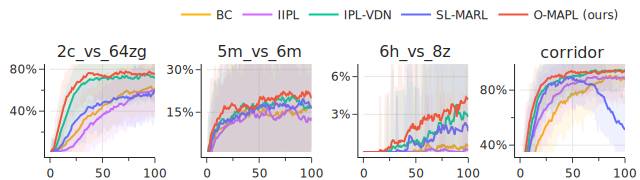

In [607]:
fig = make_subplots(rows=1, cols=4, subplot_titles=SMACV1_ENV_NAMES, horizontal_spacing=0.09)
for i, env_name in enumerate(SMACV1_ENV_NAMES):
    plotly_fig = plotly_figs[env_name]
    fig.add_traces(plotly_fig.data, rows=1, cols=i+1)
fig.update_layout(template='simple_white')
fig.update_layout(height=180, width=640)
fig = update_legend(fig, distance=1.4, tag="winrates", left_margin=50)
fig.update_yaxes(range=[0.01, 0.85], dtick=0.4, row=1, col=1)
fig.update_yaxes(range=[0.01, 0.32], dtick=0.15, row=1, col=2)
fig.update_yaxes(range=[0.0001, 0.07], dtick=0.03, row=1, col=3)
fig.update_yaxes(range=[0.35, 0.99], dtick=0.4, row=1, col=4)
fig.show("svg")
fig.write_image("graphs/smacv1_winrates.pdf")

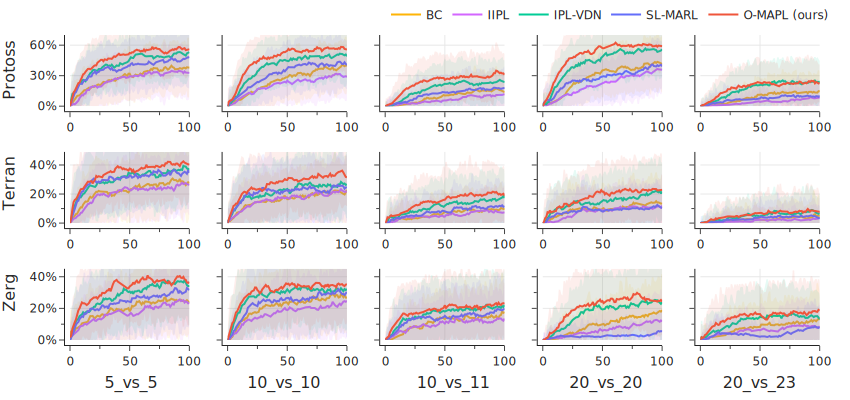

In [608]:
fig = make_subplots(
    rows=3, cols=5,
    column_titles=["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"],
    row_titles=["Protoss", "Terran", "Zerg"],
    horizontal_spacing=0.05,
    vertical_spacing=0.15
)

for i, mode in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    for j, env_name in enumerate(["protoss", "terran", "zerg"]):
        plotly_fig = plotly_figs[f"{env_name}_{mode}"]
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)

annotations = []
for i, row_title in enumerate(["Protoss", "Terran", "Zerg"]):
    annotations.append(dict(
        text=row_title,
        x=-0.08,
        y=1 - (i / 3 + 1 / 6) - 0.05 if i in [0] else 1 - (i / 3 + 1 / 6) - 0.08,
        showarrow=False,
        textangle=270
    ))

for i, col_title in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    annotations.append(dict(
        text=col_title,
        x=(i / 5 + 0.08) if i in [0, 1] else (i / 5 + 0.05),
        y=-0.18 if i in [0, 1] else -0.14,
        showarrow=False,
        textangle=0
    ))

fig.update_layout(annotations=annotations)
fig.update_layout(template='simple_white')
fig.update_layout(height=400, width=850)
fig = update_legend(fig, tag="winrates", distance=1.02, left_margin=70, bottom_margin=60)
for i in range(5):
    fig.update_yaxes(range=[0, 0.7], dtick=0.3, row=1, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[0, 0.49], dtick=0.2, row=2, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[0, 0.45], dtick=0.2, row=3, col=i+1, showticklabels=i==0)
fig.show("svg")
fig.write_image("graphs/smacv2_winrates.pdf")

In [609]:
plotly_figs = {}
for env_name in SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
    plotly_figs[env_name] = create_scatters(env_name, data_returns_llm)

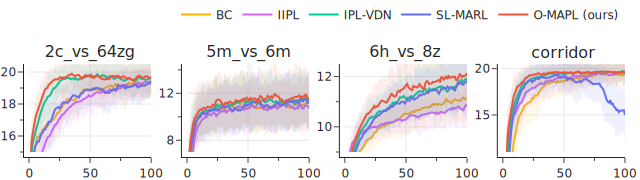

In [610]:
fig = make_subplots(rows=1, cols=4, subplot_titles=SMACV1_ENV_NAMES, horizontal_spacing=0.06)
for i, env_name in enumerate(SMACV1_ENV_NAMES):
    plotly_fig = plotly_figs[env_name]
    fig.add_traces(plotly_fig.data, rows=1, cols=i+1)
fig.update_layout(template='simple_white')
fig.update_layout(height=180, width=640)
fig = update_legend(fig, distance=1.4)
fig.update_yaxes(range=[15, 20.5], dtick=2, row=1, col=1)
fig.update_yaxes(range=[7, 14.5], dtick=4, row=1, col=2)
fig.update_yaxes(range=[9, 12.5], dtick=2, row=1, col=3)
fig.update_yaxes(range=[11, 20.5], dtick=5, row=1, col=4)
fig.show("svg")
fig.write_image("graphs/smacv1_returns_llm.pdf")

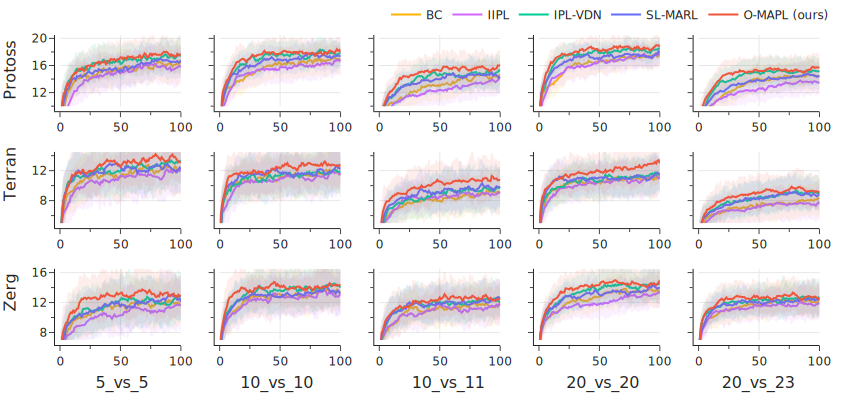

In [611]:
fig = make_subplots(
    rows=3, cols=5,
    column_titles=["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"],
    row_titles=["Protoss", "Terran", "Zerg"],
    horizontal_spacing=0.05,
    vertical_spacing=0.15
)

for i, mode in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    for j, env_name in enumerate(["protoss", "terran", "zerg"]):
        plotly_fig = plotly_figs[f"{env_name}_{mode}"]
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)

annotations = []
for i, row_title in enumerate(["Protoss", "Terran", "Zerg"]):
    annotations.append(dict(
        text=row_title,
        x=-0.065,
        y=1 - (i / 3 + 1 / 6) - 0.05 if i in [0, 1] else 1 - (i / 3 + 1 / 6 + 0.08),
        showarrow=False,
        textangle=270
    ))

for i, col_title in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    annotations.append(dict(
        text=col_title,
        x=(i / 5 + 0.08) if i in [0, 1] else (i / 5 + 0.05),
        y=-0.18 if i in [0, 1] else -0.14,
        showarrow=False,
        textangle=0
    ))

fig.update_layout(annotations=annotations)
fig.update_layout(template='simple_white')
fig.update_layout(height=400, width=850)
fig = update_legend(fig, distance=1.02, left_margin=60, bottom_margin=60)
for i in range(5):
    fig.update_yaxes(range=[10, 20.5], dtick=4, row=1, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[5, 14.5], dtick=4, row=2, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[7, 16.5], dtick=4, row=3, col=i+1, showticklabels=i==0)

fig.show("svg")
fig.write_image("graphs/smacv2_returns_llm.pdf")

In [612]:
plotly_figs = {}
for env_name in SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
    plotly_figs[env_name] = create_scatters(env_name, data_winrates_llm, tag="winrates")

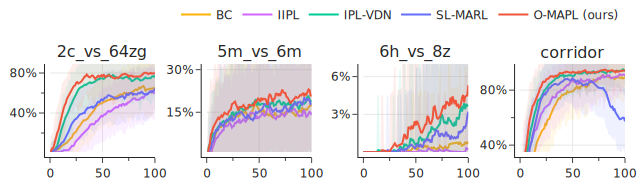

In [613]:
fig = make_subplots(rows=1, cols=4, subplot_titles=SMACV1_ENV_NAMES, horizontal_spacing=0.09)
for i, env_name in enumerate(SMACV1_ENV_NAMES):
    plotly_fig = plotly_figs[env_name]
    fig.add_traces(plotly_fig.data, rows=1, cols=i+1)
fig.update_layout(template='simple_white')
fig.update_layout(height=180, width=640)
fig = update_legend(fig, distance=1.4, tag="winrates", left_margin=50)
fig.update_yaxes(range=[0.01, 0.89], dtick=0.4, row=1, col=1)
fig.update_yaxes(range=[0.01, 0.32], dtick=0.15, row=1, col=2)
fig.update_yaxes(range=[0.0001, 0.07], dtick=0.03, row=1, col=3)
fig.update_yaxes(range=[0.35, 0.99], dtick=0.4, row=1, col=4)
fig.show("svg")
fig.write_image("graphs/smacv1_winrates_llm.pdf")

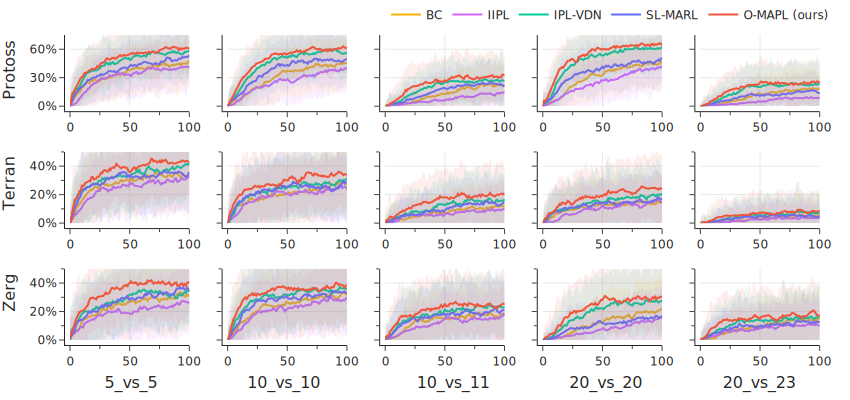

In [614]:
fig = make_subplots(
    rows=3, cols=5,
    column_titles=["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"],
    row_titles=["Protoss", "Terran", "Zerg"],
    horizontal_spacing=0.05,
    vertical_spacing=0.15
)

for i, mode in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    for j, env_name in enumerate(["protoss", "terran", "zerg"]):
        plotly_fig = plotly_figs[f"{env_name}_{mode}"]
        fig.add_traces(plotly_fig.data, rows=j+1, cols=i+1)

annotations = []
for i, row_title in enumerate(["Protoss", "Terran", "Zerg"]):
    annotations.append(dict(
        text=row_title,
        x=-0.08,
        y=1 - (i / 3 + 1 / 6) - 0.05 if i in [0] else 1 - (i / 3 + 1 / 6) - 0.08,
        showarrow=False,
        textangle=270
    ))

for i, col_title in enumerate(["5_vs_5", "10_vs_10", "10_vs_11", "20_vs_20", "20_vs_23"]):
    annotations.append(dict(
        text=col_title,
        x=(i / 5 + 0.08) if i in [0, 1] else (i / 5 + 0.05),
        y=-0.18 if i in [0, 1] else -0.14,
        showarrow=False,
        textangle=0
    ))

fig.update_layout(annotations=annotations)
fig.update_layout(template='simple_white')
fig.update_layout(height=400, width=850)
fig = update_legend(fig, tag="winrates", distance=1.02, left_margin=70, bottom_margin=60)
for i in range(5):
    fig.update_yaxes(range=[0, 0.75], dtick=0.3, row=1, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[0, 0.5], dtick=0.2, row=2, col=i+1, showticklabels=i==0)
    fig.update_yaxes(range=[0, 0.5], dtick=0.2, row=3, col=i+1, showticklabels=i==0)
fig.show("svg")
fig.write_image("graphs/smacv2_winrates_llm.pdf")

In [615]:
import h5py

In [616]:
for env_name in MAMUJOCO_ENV_NAMES + SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
    with h5py.File(f"dataset/{env_name}.h5", "r") as f:
        ob_dim = f["obs_x"].shape[-1]
        st_dim = f["states_x"].shape[-1]
        ac_dim = f["actions_x"].shape[-1] if env_name in MAMUJOCO_ENV_NAMES else f["avails_x"].shape[-1]

        n_samples = f["obs_x"].shape[0]
        max_len = f["obs_x"].shape[1] - 1

        returns = np.append(np.sum(f["rewards_x"], 1), np.sum(f["rewards_y"], 1))
        file_size = os.path.getsize(f"dataset/{env_name}.h5") / (1024 ** 2)

        data = [env_name, st_dim, ob_dim, ac_dim, n_samples, max_len, f"{returns.mean():.2f} ± {returns.std():.2f}", f"{file_size:.0f} MB"]

        print("\t".join([str(x) for x in data]))

Hopper-v2	42	14	1	1000	1000	1354.04 ± 1121.60	255 MB
Ant-v2	226	113	4	1000	1000	1514.98 ± 435.85	1003 MB
HalfCheetah-v2	138	23	1	1000	1000	1640.52 ± 1175.78	1802 MB
2c_vs_64zg	1350	478	70	2000	280	13.99 ± 4.75	401 MB
5m_vs_6m	780	124	12	2000	36	13.26 ± 5.02	72 MB
6h_vs_8z	1278	172	14	2000	48	13.01 ± 3.95	182 MB
corridor	2610	346	30	2000	394	12.69 ± 6.30	979 MB
protoss_5_vs_5	130	92	11	2000	142	16.07 ± 4.94	56 MB
protoss_10_vs_10	310	182	16	2000	178	15.72 ± 4.28	209 MB
protoss_10_vs_11	327	191	17	2000	146	15.45 ± 4.85	218 MB
protoss_20_vs_20	820	362	26	2000	200	15.63 ± 4.76	726 MB
protoss_20_vs_23	901	389	29	2000	200	14.44 ± 4.73	799 MB
terran_5_vs_5	120	82	11	2000	200	16.20 ± 6.37	44 MB
terran_10_vs_10	290	162	16	2000	200	14.86 ± 5.78	151 MB
terran_10_vs_11	306	170	17	2000	200	13.52 ± 5.44	165 MB
terran_20_vs_20	780	322	26	2000	200	13.52 ± 5.76	530 MB
terran_20_vs_23	858	346	29	2000	200	10.67 ± 5.11	563 MB
zerg_5_vs_5	120	82	11	2000	57	14.79 ± 7.70	31 MB
zerg_10_vs_10	290	162	16	2000	7

In [617]:
for env_name in SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
    path = f"dataset/llm_{env_name}_out.jsonl"
    total_completion_tokens = 0
    total_prompt_tokens = 0
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)["response"]["body"]["usage"]
            total_completion_tokens += data["completion_tokens"]
            total_prompt_tokens += data["prompt_tokens"]
        print(f"{env_name}\t{total_completion_tokens}\t{total_prompt_tokens}")

2c_vs_64zg	5920	2498000
5m_vs_6m	5913	1386000
6h_vs_8z	5941	1462000
corridor	5926	1772000
protoss_5_vs_5	5920	1460000
protoss_10_vs_10	5918	1660000
protoss_10_vs_11	5940	1680000
protoss_20_vs_20	5901	2060000
protoss_20_vs_23	5990	2122000
terran_5_vs_5	5990	1442000
terran_10_vs_10	5925	1642000
terran_10_vs_11	5930	1662000
terran_20_vs_20	5944	2042000
terran_20_vs_23	5977	2104000
zerg_5_vs_5	5940	1448000
zerg_10_vs_10	5914	1648000
zerg_10_vs_11	5912	1668000
zerg_20_vs_20	5942	2048000
zerg_20_vs_23	5913	2110000


In [618]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [619]:
def read_tensorboard(logdir):
    files = os.listdir(logdir)
    path = f"{logdir}/{files[0]}"
    tb = EventAccumulator(path)
    tb.Reload()
    data = {}
    for tag in ["high", "low"]:
        for item in tb.Scalars(f"logits/{tag}"):
            if item.step not in data:
                data[item.step] = {}
            data[item.step][tag] = item.value
    max_step = max(data.keys())
    high = data[max_step]["high"]
    low = data[max_step]["low"]
    return high, low

In [620]:
def analyze_recovered_rewards(use_llm):
    for env_name in SMACV1_ENV_NAMES + SMACV2_ENV_NAMES:
        all_highs = []
        all_lows = []
        for seed in range(4):
            path = f"logs/IPMAL/{env_name}_llm/seed{seed}" if use_llm else f"logs/IPMAL/{env_name}/seed{seed}"
            high, low = read_tensorboard(path)
            all_highs.append(high)
            all_lows.append(low)
        high_mean = np.mean(all_highs)
        high_std = np.std(all_highs)
        low_mean = np.mean(all_lows)
        low_std = np.std(all_lows)
        print(f"{env_name}\t{low_mean:.2f} ± {low_std:.2f}\t{high_mean:.2f} ± {high_std:.2f}")

In [621]:
analyze_recovered_rewards(use_llm=False)

2c_vs_64zg	-8.36 ± 0.26	9.25 ± 0.67
5m_vs_6m	-4.49 ± 0.12	4.80 ± 0.15
6h_vs_8z	-4.72 ± 0.28	5.15 ± 0.22
corridor	-12.59 ± 0.31	11.23 ± 1.06
protoss_5_vs_5	-6.31 ± 0.22	6.54 ± 0.51
protoss_10_vs_10	-7.73 ± 0.18	7.92 ± 0.32
protoss_10_vs_11	-7.95 ± 0.69	8.31 ± 0.91
protoss_20_vs_20	-8.31 ± 0.35	8.19 ± 0.16
protoss_20_vs_23	-8.01 ± 0.22	9.10 ± 0.14
terran_5_vs_5	-6.85 ± 0.30	6.93 ± 0.56
terran_10_vs_10	-8.25 ± 0.82	7.35 ± 0.61
terran_10_vs_11	-8.53 ± 0.67	9.62 ± 0.54
terran_20_vs_20	-8.59 ± 0.36	8.44 ± 0.22
terran_20_vs_23	-8.49 ± 0.65	8.91 ± 0.27
zerg_5_vs_5	-3.74 ± 0.14	3.64 ± 0.14
zerg_10_vs_10	-4.16 ± 0.16	4.27 ± 0.16
zerg_10_vs_11	-4.54 ± 0.06	4.60 ± 0.14
zerg_20_vs_20	-5.31 ± 0.08	5.25 ± 0.20
zerg_20_vs_23	-4.78 ± 0.12	5.08 ± 0.15


In [622]:
analyze_recovered_rewards(use_llm=True)

2c_vs_64zg	-12.87 ± 0.73	14.14 ± 0.80
5m_vs_6m	-4.02 ± 0.20	4.51 ± 0.18
6h_vs_8z	-5.11 ± 0.32	5.28 ± 0.16
corridor	-12.97 ± 0.33	10.93 ± 0.45
protoss_5_vs_5	-8.06 ± 0.64	7.46 ± 0.77
protoss_10_vs_10	-10.65 ± 1.15	9.32 ± 0.91
protoss_10_vs_11	-11.01 ± 0.93	10.43 ± 1.57
protoss_20_vs_20	-10.57 ± 0.86	9.54 ± 0.74
protoss_20_vs_23	-12.17 ± 0.72	12.09 ± 0.80
terran_5_vs_5	-7.85 ± 0.27	7.82 ± 0.57
terran_10_vs_10	-10.73 ± 1.49	8.16 ± 0.56
terran_10_vs_11	-9.18 ± 0.23	10.97 ± 1.38
terran_20_vs_20	-10.44 ± 0.96	10.79 ± 1.00
terran_20_vs_23	-14.90 ± 2.06	17.95 ± 2.91
zerg_5_vs_5	-5.09 ± 0.19	3.51 ± 0.06
zerg_10_vs_10	-5.93 ± 0.43	6.14 ± 0.64
zerg_10_vs_11	-7.28 ± 0.50	6.20 ± 0.50
zerg_20_vs_20	-7.71 ± 0.54	7.24 ± 0.23
zerg_20_vs_23	-8.26 ± 1.13	8.00 ± 0.43
